### Analysis software development v2 

Goal: establish smooth reading of the binary DAQ datafiles

In [1]:
import sys
sys.path.insert(0,'python/')
import struct
import matplotlib.pyplot as plt
from scipy.stats import norm

# import data handling class
from DT5550 import *

Open a datafile and read the data

In [2]:
#
# open the datfile / data directory
#
    
#
# loop over all the events
#
dt_max = 10

Etot = []
Etot_sel = []
tt = []
tt3 = []

nmax = 9999

#
# connect to the data
#
io = DT5550(indir='C:/data/20220217_092209/')

nf = 0

dtime = []
for file in io.filenames:
    io.open_data(file)
    nf = nf + 1
    if nf>nmax:
        break
    while io.read_event() == 0: 
        # data: io.Q[0:ndet-1] -> energy
        #       io.ph[0:ndet-1] -> peak height
        #       io.t[0:ndet-1] -> time without timewalk correction
        #       io.tc[0:ndet-1] -> time with timewalk correction
        #       io.valid[0:ndet-1] -> valid bit = 1 for valid data
        #       io.R[0:ndet-1] -> peak/area ratio
        
        #
        # count the number of valida hits in this event
        #
        nh = io.valid.sum()
        
        Etot.append(io.Q.sum())
        
        #
        # select events where 
        # 1. the total energy of a Na22 decay is observed
        # 2. there are 3 or more detectors that registers an energy deposit
        #
        if (nh>=3) and (io.Q.sum()>2150) and (io.Q.sum()<2400):
            #
            # 1274 gamma ray from Ne22
            #
            i0 = -1 # index of detector that registers the 1274keV event 
            for idet in range(N_DETECTOR):
                #
                # if the energy is within 100keV of the 1274keV gamma ray line, we found it (check if this is OK)
                #
                rr = io.R[idet]
                rmean = io.config['detector_settings'][idet]['RMEAN']
                rsig = io.config['detector_settings'][idet]['RSIGMA']
                
                if abs(io.Q[idet]-1274)<100 and (io.valid[idet]) and (abs(rr-rmean) < 3*rsig):
                    #print('1274keV ', idet,'t =',io.tc[idet],'E =',io.Q[idet])
                    t0 = io.tc[idet]
                    i0 = idet
         
            #
            # look at the other energy deposits in the event
            #
            nn = 0
            esum = 0
            dt = []
            for idet in range(N_DETECTOR):
                # if the hits is valid AND the detector is not the one that saw the 1274keV gamma ray
                rr = io.R[idet]
                rmean = io.config['detector_settings'][idet]['RMEAN']
                rsig = io.config['detector_settings'][idet]['RSIGMA']
                if (io.valid[idet]) and (idet != i0) and (abs(rr - rmean) < 3*rsig):
                    nn = nn + 1
                    esum = esum + io.Q[idet]
                    dt.append(io.tc[idet]-t0) # time difference wrt to 1274keV gamma ray
            dt = np.array(dt)
            
            #
            # continue with this event if:
            # 1. there are two or more hits beside the 1274keV gamma ray (should be most, due to earlier selection)
            # 2. a 1274keV gamma ray is actually found
            #
            if (nn>=2) and (i0!=-1):
                # the energy of the hits other than the 1274keV gamma ray is within 100keV of 2*m_electron
                if abs(esum-1022)<100:
                    #
                    # calculate the variance of the time-difference of the 'other' hits
                    #
                    ss = np.sqrt(dt.var())
                    #
                    # if the other hits are within 10ns (!) then we are likely dealing with a true multi-gamma decay (mult is 2, 3, ..)
                    #
                    if ss<10: 
                        tt.append(dt.mean())
                        Etot_sel.append(io.Q.sum())
                        if nn == 3:
                            tt3.append(dt.mean())
                    
print('Processing done')

Etot = np.array(Etot,dtype=object)
Etot_sel = np.array(Etot_sel,dtype=object)
tt3 = np.array(tt3,dtype=object)


#r = np.array(r, dtype=object)

DT5550:: Data recorded with config:  C:/data/20220217_092209\config_20220217_092209.json
DT5550:: Open data file: C:/data/20220217_092209\data_20220217_092209_0.raw
DT5550:: Open data file: C:/data/20220217_092209\data_20220217_092209_1.raw
DT5550:: Open data file: C:/data/20220217_092209\data_20220217_092209_2.raw
DT5550:: Open data file: C:/data/20220217_092209\data_20220217_092209_3.raw
DT5550:: Open data file: C:/data/20220217_092209\data_20220217_092209_4.raw
DT5550:: Open data file: C:/data/20220217_092209\data_20220217_092209_5.raw
DT5550:: Open data file: C:/data/20220217_092209\data_20220217_092209_8.raw
DT5550:: Open data file: C:/data/20220217_092209\data_20220217_092209_9.raw
DT5550:: Open data file: C:/data/20220217_092209\data_20220217_092209_10.raw
DT5550:: Open data file: C:/data/20220217_092209\data_20220217_092209_11.raw
DT5550:: Open data file: C:/data/20220217_092209\data_20220217_092209_12.raw
DT5550:: Open data file: C:/data/20220217_092209\data_20220217_092209_13

#### Plot time lifetime

In [25]:
from scipy import special
from lmfit import Model, Parameters, Minimizer, report_fit

def fcn2min(params, x, data):
    
    A0 = params['A0']
    sigma = params['sigma']
    const = params['const']
    
    arg = -x**2/sigma**2/2
    model = A0*np.exp(arg)/sigma/np.sqrt(2*np.pi) + const
    return model - data

def delta_time(x, A0, A1, tau0, sigma, C, A2, tau2):
    #tau = params['tau']
    #sigma = params['sigma']
    #A = params['A']
    #C = params['C']
    
    lam = 1./tau0
    
    arg = -x**2/sigma**2/2
    fval = A0*np.exp(arg)/sigma/np.sqrt(2*np.pi)
    
    arg0 = -lam*(x-sigma**2*lam/2.)
    arg1 = (x-sigma**2*lam)/np.sqrt(2.)/sigma
    fval = fval+A1*np.exp(arg0)*(1+special.erf(arg1))/2

    fval = fval + A2*np.exp(-x/tau2)*np.heaviside(x,0)
    
    fval = fval + C
    
    return fval

def delta_time1(x, A0, A1, tau0, sigma, C, A2, tau2, f):
    #tau = params['tau']
    #sigma = params['sigma']
    #A = params['A']
    #C = params['C']
    
    lam = 1./tau0
    
    arg0 = -x**2/sigma**2/2
    
    sigma1=2.5*sigma
    arg1 = -x**2/sigma1**2/2
    fval = A0*(np.exp(arg0)/sigma/np.sqrt(2*np.pi)*f + (1-f)*np.exp(arg1)/sigma1/np.sqrt(2*np.pi))
    
    arg0 = -lam*(x-sigma**2*lam/2.)
    arg1 = (x-sigma**2*lam)/np.sqrt(2.)/sigma
    fval = fval+A1*np.exp(arg0)*(1+special.erf(arg1))/2

    fval = fval + A2*np.exp(-x/tau2)*np.heaviside(x,0)
    
    fval = fval + C
    
    return fval

In [26]:
def signal(t, c, a, tau):
    return c+a*np.exp(-t/tau)

In [44]:
#tt=np.array(tt)+0.1

In [71]:
xr = (-250,500)
bins = 125
cc = 140

y, xe = np.histogram(tt, bins=bins, range=xr)
x = .5 * (xe[:-1] + xe[1:])

#for i in range(len(x)):
#    print(x[i], y[i])

[1.70575786e+07 6.78295754e+05 2.26881917e+00 2.34626444e+00
 3.44094258e+02 4.17533999e+02 7.85140075e+01]


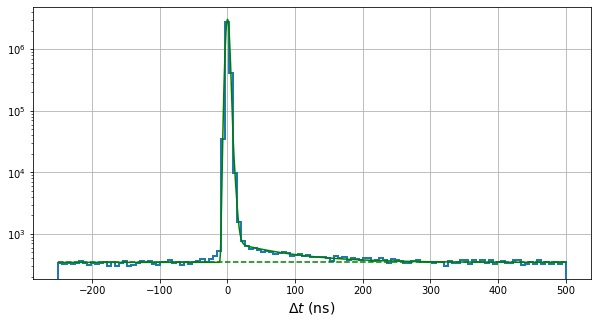

In [74]:
from scipy.optimize import curve_fit

plt.figure(figsize=(10,5))
popt,pcov = curve_fit(delta_time, x, y, sigma=np.sqrt(y), 
                      p0=[1e7, 7e4, 4.4, 2.3, 445, 100, 100], 
                      bounds=((-np.inf, -np.inf, -np.inf, -np.inf, -np.inf, 0, 0), (np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf)))
#plt.errorbar(x,y,yerr=np.sqrt(y), marker='o', markersize=4, ls='none' ) 
plt.hist(tt,bins=bins, range=xr, histtype='step', linewidth=2)
xx = np.linspace(xr[0],xr[1],1000)
plt.grid()
plt.plot(xx,delta_time(xx, *popt), color='green')
plt.plot([xr[0],xr[1]],[popt[4],popt[4]], '--', color='green')
print(popt)
#plt.ylim([100,1000])
plt.yscale('log')
plt.xlabel('$\Delta t$ (ns)',fontsize=14)
plt.show()

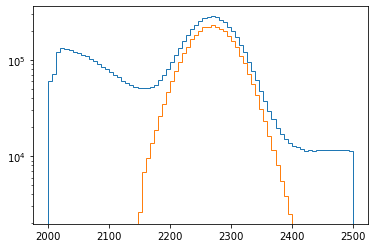

In [64]:
bins=75
plt.hist(Etot,bins=bins, range=(2000,2500), histtype='step')
plt.hist(Etot_sel,bins=bins, range=(2000,2500), histtype='step')
plt.yscale('log')
plt.show()

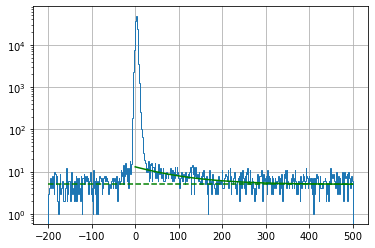

In [107]:
bins = 500
plt.hist(tt3,bins=bins,range=(-200,500),histtype='step')
yy = 5
plt.plot([-200,500],[yy,yy],'--',color='green')
plt.grid()
xx=np.linspace(0,500,100)
plt.plot(xx,8*np.exp(-xx/100)+5,color='green')
plt.yscale('log')
plt.show()

In [10]:
special.erfc(-10000)

2.0